Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 1.1min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  45.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.5min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  43.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.0min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.1min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.1min
[CV] END max_depth

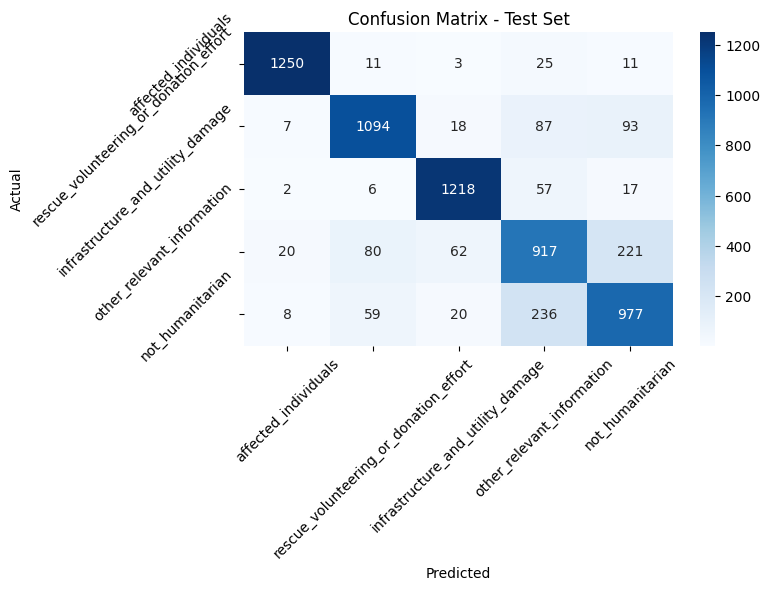

In [26]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Load dataset
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Clean column names
df.columns = df.columns.str.strip().str.lower()

# Check necessary columns
if 'humanitarian_class' not in df.columns or 'processed_data' not in df.columns:
    raise KeyError("Missing required columns.")

# Clean labels and text
df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()
df['processed_data'] = df['processed_data'].fillna("")

# Label encoding
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}
df['label'] = df['humanitarian_class'].map(label_map)

# Handcrafted features
df['tweet_length'] = df['processed_data'].apply(len)
df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

# Vectorize features for SMOTE
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_text = vectorizer.fit_transform(df['processed_data'])

scaler = StandardScaler()
X_hand = scaler.fit_transform(df[['tweet_length', 'num_hashtags', 'num_mentions']])

# Combine features
X_combined = np.hstack((X_text.toarray(), X_hand))
y = df['label'].values

# Apply SMOTE before split
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_combined, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Reconstruct TF-IDF and handcrafted features after split for clarity
X_train_text = X_train[:, :5000]
X_train_hand = X_train[:, 5000:]

X_test_text = X_test[:, :5000]
X_test_hand = X_test[:, 5000:]

# Train Random Forest with hyperparameter tuning
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10, cv=3,
    scoring='accuracy', n_jobs=-1, verbose=2, random_state=42
)
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_
print("✅ Best RandomForest Parameters:", random_search.best_params_)

# Fit and save model
best_rf.fit(X_train, y_train)
joblib.dump(best_rf, "/kaggle/working/random_forest_best.pkl")
print("✅ RandomForest model saved as 'random_forest_best.pkl'.")

# Predict on test set
y_pred = best_rf.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_map.keys())
print(f"\n✅ Test Accuracy: {acc:.4f}")
print("📋 Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
